In [1]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [2]:
train_dir = Path('skin diseases/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))
test_dir = Path('skin diseases/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))
val_dir = Path('skin diseases/valid')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [3]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [4]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [5]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 7012

Number of different labels: 12

Labels: ['bcc' 'pigmented benign keratosis' 'acne' 'seborrheic keratosis'
 'basal cell carcinoma' 'squamous cell carcinoma' 'atopic' 'melanoma'
 'nevus' 'vascular lesion' 'dermatofibroma' 'actinic keratosis']


In [6]:
train_df.head(5)

,Filepath,Label
0,skin diseases/train/bcc/basal-cell-carcinoma-p...,bcc
1,skin diseases/train/pigmented benign keratosis...,pigmented benign keratosis
2,skin diseases/train/acne/acne-open-comedo-14_j...,acne
3,skin diseases/train/bcc/ISIC_0065874_jpg.rf.86...,bcc
4,skin diseases/train/acne/acne-face-2-22__Prote...,acne


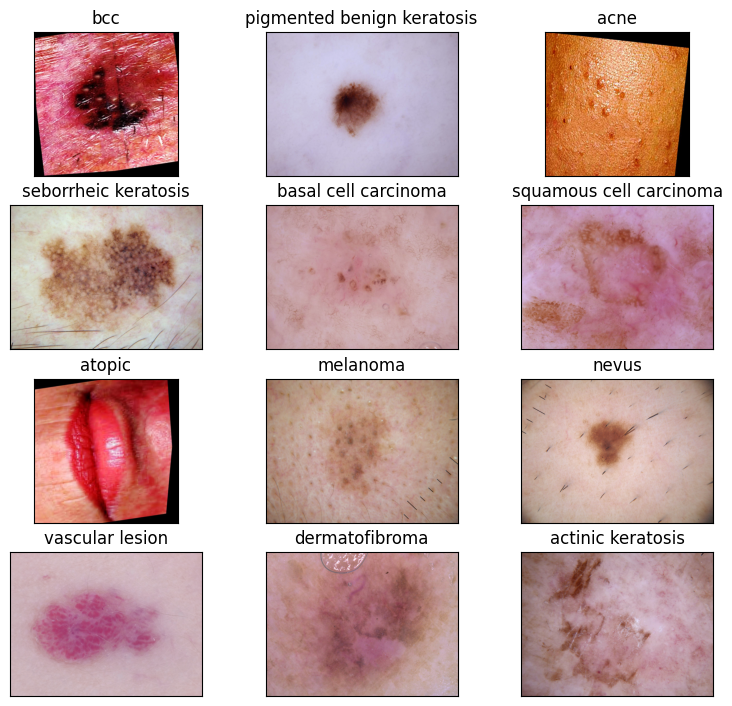

In [7]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 7012 validated image filenames belonging to 12 classes.


In [10]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 323 validated image filenames belonging to 12 classes.


In [11]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 323 validated image filenames belonging to 12 classes.


In [12]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_images,
    validation_data=train_images,
    batch_size = 32,
    epochs=10, #5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 75s 333ms/step - accuracy: 0.5509 - loss: 1.2059 - val_accuracy: 0.7450 - val_loss: 0.6800
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 79s 355ms/step - accuracy: 0.7215 - loss: 0.7107 - val_accuracy: 0.7788 - val_loss: 0.5921
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 369ms/step - accuracy: 0.7825 - loss: 0.5800 - val_accuracy: 0.8109 - val_loss: 0.4976
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 86s 387ms/step - accuracy: 0.8064 - loss: 0.4960 - val_accuracy: 0.8448 - val_loss: 0.4203
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 89s 400ms/step - accuracy: 0.8401 - loss: 0.4211 - val_accuracy: 0.8709 - val_loss: 0.3495
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 86s 389ms/step - accuracy: 0.8792 - loss: 0.3316 - val_accuracy: 0.7801 - val_loss: 0.5845
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 91s 413ms/step - accuracy: 0.8679 - loss: 0.3610 - val_accuracy: 0.9127 - val_loss: 0.2529
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 89s 400ms/step - accuracy: 0.9054 - loss: 0.2592 - val

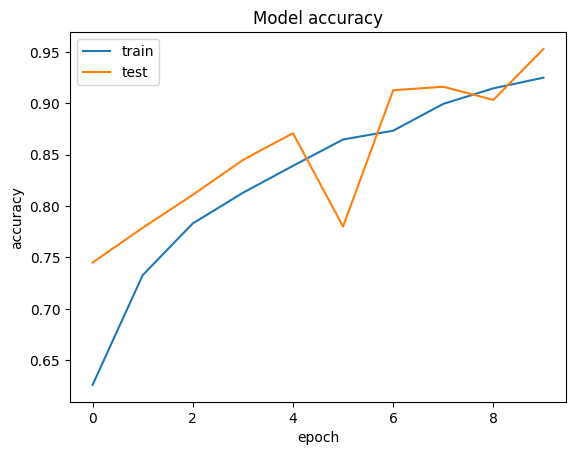

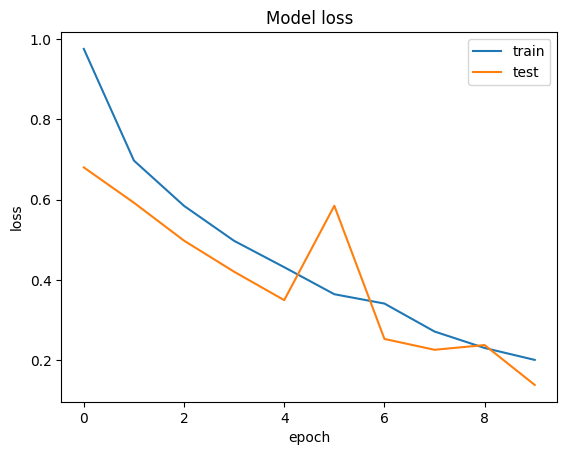

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])

plt.show()

In [16]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step


['nevus',
 'atopic',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'atopic',
 'pigmented benign keratosis',
 'squamous cell carcinoma',
 'bcc',
 'pigmented benign keratosis',
 'nevus',
 'bcc',
 'bcc',
 'nevus',
 'atopic',
 'bcc',
 'acne',
 'atopic',
 'pigmented benign keratosis',
 'bcc',
 'bcc',
 'atopic',
 'acne',
 'actinic keratosis',
 'nevus',
 'bcc',
 'nevus',
 'nevus',
 'bcc',
 'melanoma',
 'bcc',
 'basal cell carcinoma',
 'pigmented benign keratosis',
 'atopic',
 'nevus',
 'pigmented benign keratosis',
 'atopic',
 'atopic',
 'nevus',
 'atopic',
 'acne',
 'bcc',
 'acne',
 'vascular lesion',
 'nevus',
 'bcc',
 'bcc',
 'acne',
 'atopic',
 'acne',
 'acne',
 'basal cell carcinoma',
 'squamous cell carcinoma',
 'atopic',
 'atopic',
 'atopic',
 'bcc',
 'bcc',
 'bcc',
 'bcc',
 'bcc',
 'bcc',
 'acne',
 'atopic',
 'bcc',
 'melanoma',
 'nevus',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'acne',
 'pigmented benign keratosis',
 'basal cell carcinoma',
 'bcc',
 '

In [17]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [18]:
img = output('skin diseases/test/acne/acne-pustular-49_jpg.rf.f18828459f639292e759499f6be1c771.jpg')
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


'acne'

In [19]:
model.save('Skin_Diseases_Model.h5')

In [21]:
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np

In [23]:
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

pred2 = [labels[k] for k in pred] 
y_test = [labels[k] for k in test_images.classes]
from sklearn.metrics import accuracy_score
recall = recall_score(y_test, pred2,average='macro',zero_division=1)
precision = precision_score(y_test, pred2,average='macro',zero_division=1)

print(f'Recall score: {100*recall:.2f}%')
print(f'Precision score: {100*precision:.2f}%')

Recall score: 54.75%
Precision score: 62.64%


Confusion Matrix:
[[51  0 13  0  3  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  1 12  2  0  0  0]
 [ 8  0 50  0  5  0  0  0  0  0  0  4]
 [ 0  0  0 10  0  0  2  0  2  0  2  0]
 [ 3  0  4  0 62  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  5  1  4  4  0  1  0]
 [ 0  0  1  0  1  0  3  8  2  0  1  0]
 [ 0  0  0  0  0  0  0 12  4  0  0  0]
 [ 0  2  0  2  0  0  1  0 10  0  1  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  2  3  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  3]]


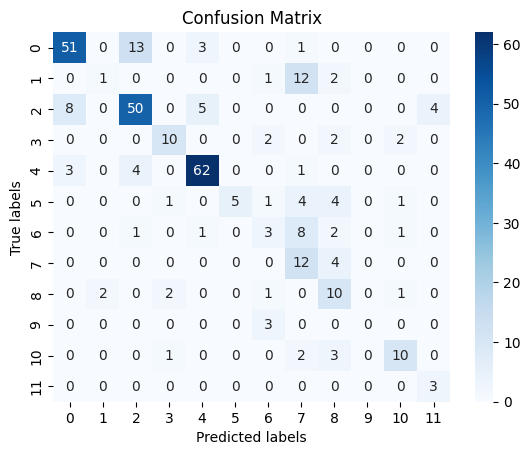

In [24]:
cm = confusion_matrix(y_test, pred2)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# If you want to visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()